# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [293]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

The goal of this analysis to understand Starbucks app users behaviour in regards to Age, Gender, and income group. It will follow these steps:
###### 1. Exploratoray look 
###### 2. Data Preprocessing
###### 3. Data analysis
###### 4. Modelling.
###### 5. Evaluation.

## 1. Expolatoray Look

### a. Portfolio

In [294]:
# What does the data frame look like
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [295]:
# What types of offers
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [296]:
def bar_plot(df, column, title):
    df.groupby(column).size().plot(kind = 'barh',title = title,color = '#761580')

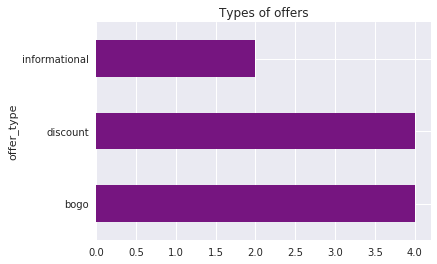

In [297]:
bar_plot(portfolio, 'offer_type','Types of offers')

Seems that there are Bogos and discount are the more common type

### b. profile

In [298]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


It seems that 118 usually means that the customers didn't fill the required columns or no information 



to confirm

###### Age

In [299]:
profile[profile['age'] == 118].shape

(2175, 5)

In [300]:
profile[profile['age'] == 118].income.unique()

array([ nan])

In [301]:
profile[profile['age'] == 118].gender.unique()

array([None], dtype=object)

I will remove their values from the analysis for two reasons:
1. Small number 
2. Don't have the data that I am trying to analyze

In [302]:
cleaned_profile = profile[profile['age'] != 118]
cleaned_profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [303]:
# Check Age 
cleaned_profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


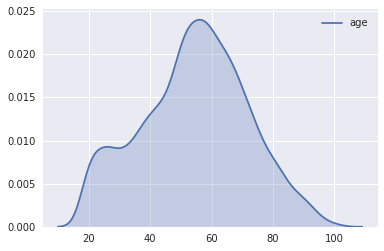

In [304]:

sns.kdeplot(cleaned_profile.age, label='age', shade=True)


###### income

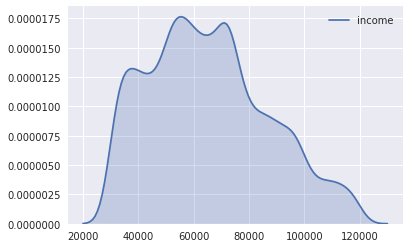

In [305]:
sns.kdeplot(cleaned_profile.income, label='income', shade=True)


###### gender

In [306]:
cleaned_profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

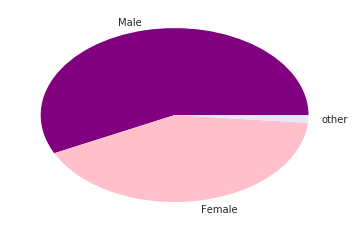

In [307]:
gendervalues = cleaned_profile.gender.value_counts()

x=plt.pie(gendervalues,labels =['Male','Female','other'], colors = ['purple','pink','lavender'])


### c.transcript

In [308]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [309]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [310]:
transcript[transcript['event'] == 'offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [311]:
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [312]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [313]:
transcript[transcript['event'] == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


There are three types of dictionaries in the value columns
1. transaction which has the amount of the transaction
2. offer completed which contains the offer id and the name is (offer_id)
3. offer viewed and offer recieved contain the offer id and the name is (offer id)

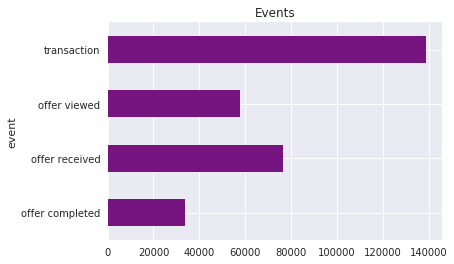

In [314]:
bar_plot(transcript, 'event', 'Events')

## 2. Data Preprocessing

###### i) Portfolio Cleaning

rename the ID columns for better clarity 

In [315]:
cleaned_portfolio = portfolio.rename(columns = {'id':'offer_id','difficulty':'offer_difficulty','reward':'offer_reward','channels':'offer_channels'})

In [316]:
cleaned_portfolio.head()

,offer_channels,offer_difficulty,duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


###### ii) transcript Cleaning

First I will need to fix the value column see the state of offers

In [317]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [318]:
#split the value column
transcript['offer_id'] = transcript['value'].apply(lambda x:x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x:x.get('offer id'))
transcript['customer_spending'] = transcript['value'].apply(lambda x:x.get('amount'))
transcript['customer_reward'] = transcript['value'].apply(lambda x:x.get('reward'))

transcript['offer_id'] = transcript.apply(lambda x:x['offer id'] if x['offer_id'] == None  else x['offer_id'],axis = 1)

transcript.drop('offer id',  1, inplace = True)
transcript.drop('value',  1, inplace = True)

transcript.fillna(0, inplace = True)

In [319]:
transcript.head()

,event,person,time,offer_id,customer_spending,customer_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [320]:
# Renaming for calrity
transcript = transcript.rename(columns ={'person':'customer_id'})

In [321]:
transcript.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [322]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event                306534 non-null object
customer_id          306534 non-null object
time                 306534 non-null int64
offer_id             306534 non-null object
customer_spending    306534 non-null float64
customer_reward      306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


###### iii) profile

In [323]:
cleaned_profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [324]:
# rename Id to customer ID to merge
cleaned_profile = cleaned_profile.rename(columns ={'id':'customer_id'})

In [325]:
cleaned_profile.head()

,age,became_member_on,gender,customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


For the age columns I am going to put in an arbitary age groups 
1. College + High school students (18, 24)
2. younger adults (25, 45)
3. Adults (46, 60)
4. Retires (61,80)
5. Very old (80+)

In [326]:
 cleaned_profile.head()



,age,became_member_on,gender,customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [327]:
# Replace the age column with age group column and drop age
bins = [18,24,45,60,80,101]
lables = ['(18, 24)','(25, 45)','(46, 60)','(61,80)','(80+)']
cleaned_profile['Age_Group'] = pd.cut(cleaned_profile['age'], bins=bins, labels=lables, right=False)
cleaned_profile=cleaned_profile.drop('age',axis=1)

In [328]:
cleaned_profile.head()

,became_member_on,gender,customer_id,income,Age_Group
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,"(46, 60)"
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"(61,80)"
5,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,"(61,80)"
8,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,"(61,80)"
12,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"(46, 60)"


Final step is to transform the became_memmber_on column into datetime column

In [329]:
cleaned_profile['became_member_on'] = pd.to_datetime(cleaned_profile['became_member_on'],format="%Y%m%d")

In [330]:
cleaned_profile.head()

,became_member_on,gender,customer_id,income,Age_Group
1,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,"(46, 60)"
3,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"(61,80)"
5,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,"(61,80)"
8,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,"(61,80)"
12,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"(46, 60)"


In [331]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
Age_Group           14820 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 593.8+ KB


#### Merge the dataframes

In [332]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
customer_id         14825 non-null object
income              14825 non-null float64
Age_Group           14820 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 593.8+ KB


In [333]:
cleaned_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
offer_channels      10 non-null object
offer_difficulty    10 non-null int64
duration            10 non-null int64
offer_id            10 non-null object
offer_type          10 non-null object
offer_reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [334]:
transcript.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [335]:
merged_df = pd.merge(transcript, cleaned_portfolio, on='offer_id')
merged_df.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5


In [336]:
Starbucks_data = pd.merge(merged_df,cleaned_profile,on = 'customer_id')

In [337]:
Starbucks_data.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_reward,became_member_on,gender,income,Age_Group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"


With This The Data is ready to be Explored and model. 

Income average income offer completed
ages
offer distribuation
males and females: ages income offer types 

[Source 1](https://towardsdatascience.com/data-visualization-with-pandas-1571bbc541c8)
[Source 2](https://realpython.com/pandas-plot-python/)

#### Income Distribution for starbucks customers

In [338]:
Starbucks_data.income.describe()

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64

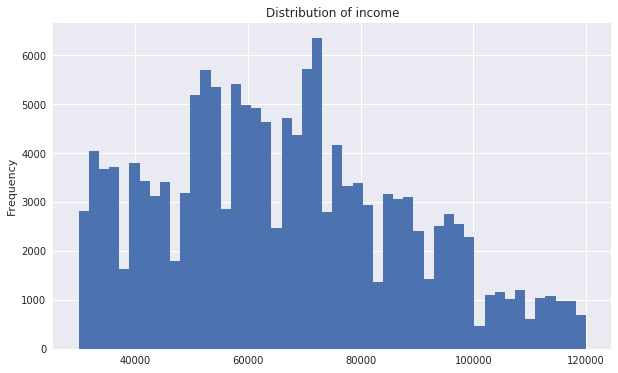

In [339]:
Starbucks_data['income'].plot(kind='hist',bins=50, figsize=(10,6), title='Distribution of income')

##### Offer 

###### 1. Which offer were more common

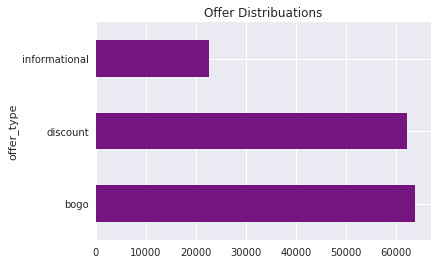

In [340]:
bar_plot(Starbucks_data,'offer_type','Offer Distribuations')

In [341]:
Starbucks_data.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_reward,became_member_on,gender,income,Age_Group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"


##### Age groups

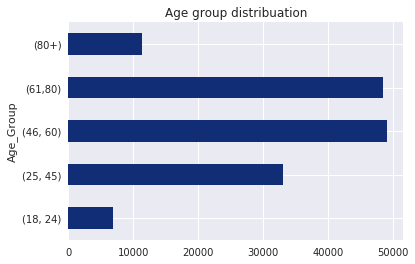

In [342]:
Starbucks_data.groupby('Age_Group').size().plot(kind = 'barh',title = 'Age group distribuation',color = '#102D75')

##### Offer type and response

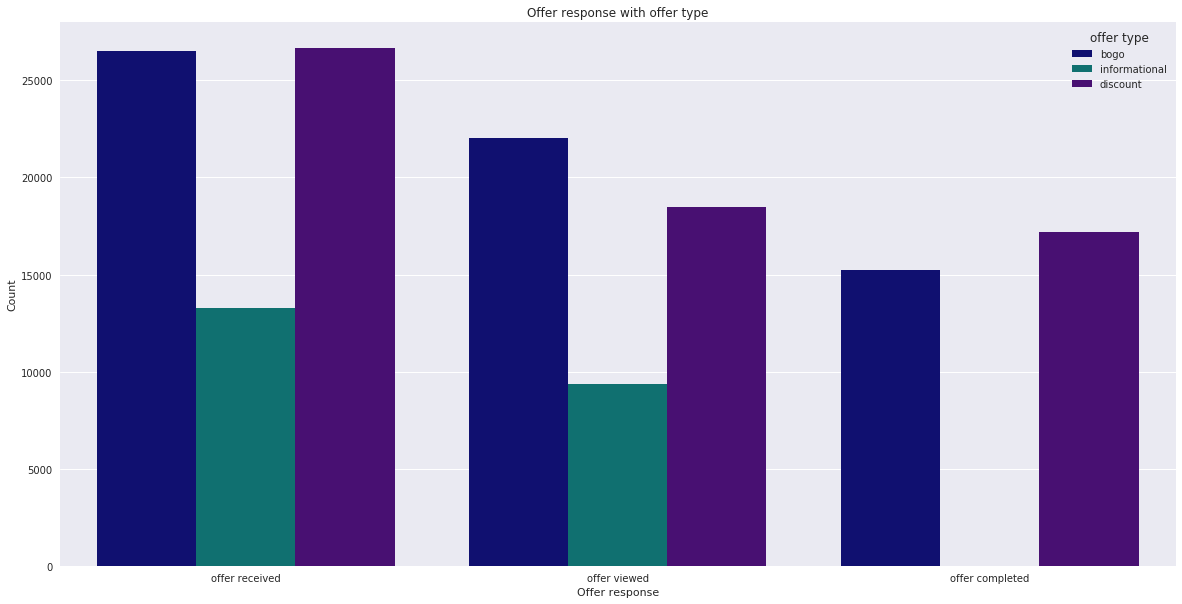

In [345]:

plt.figure(figsize=(20,10))
sns.countplot(x= "event", hue= "offer_type", palette=['Navy','Teal','Indigo'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with offer type')
plt.ylabel('Count')
plt.xlabel('Offer response')
plt.legend(title='offer type')

##### Age and offer response

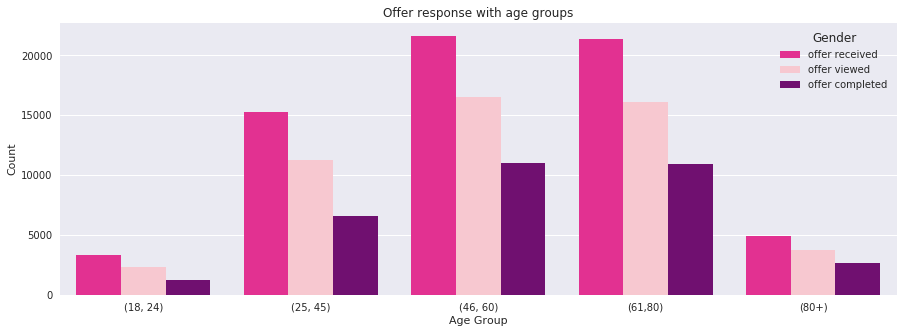

In [272]:

plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_Group", hue= "event", palette=['DeepPink','pink','purple'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

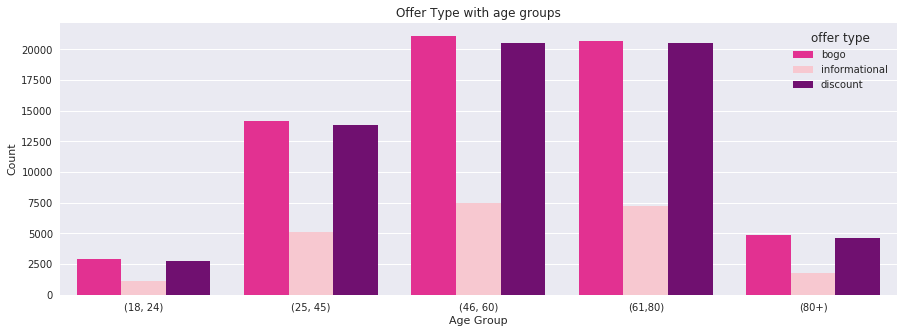

In [347]:

plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_Group", hue= "offer_type", palette=['DeepPink','pink','purple'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer Type with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='offer type')

##### Gender and offer response

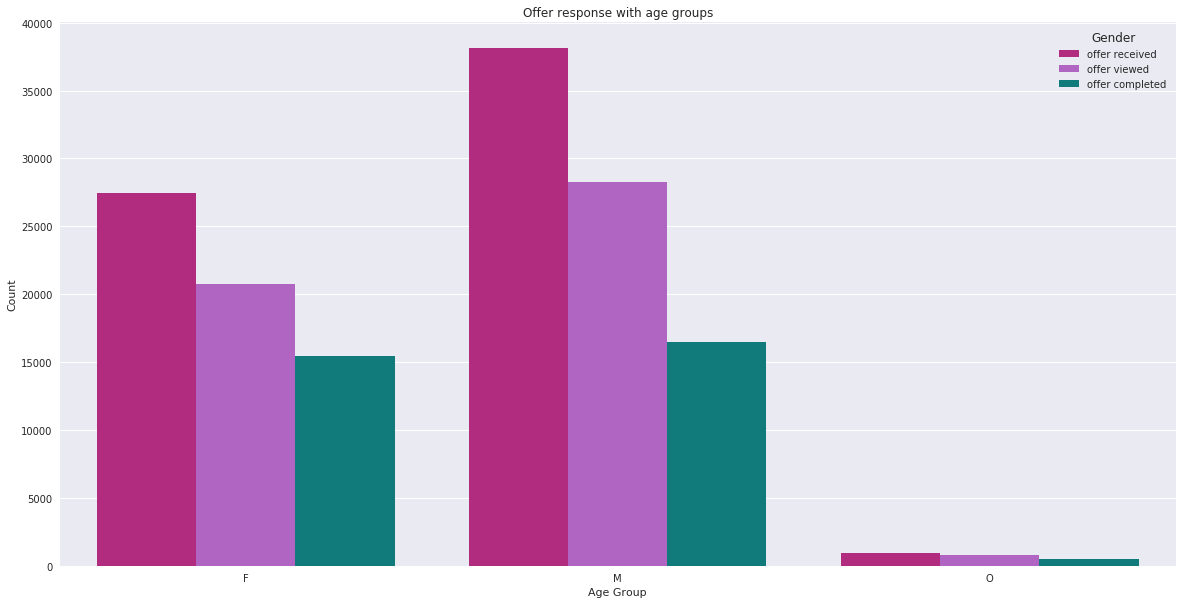

In [273]:

plt.figure(figsize=(20,10))
sns.countplot(x= "gender", hue= "event", palette=['MediumVioletRed','MediumOrchid','DarkCyan'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

##### gender  and offer type

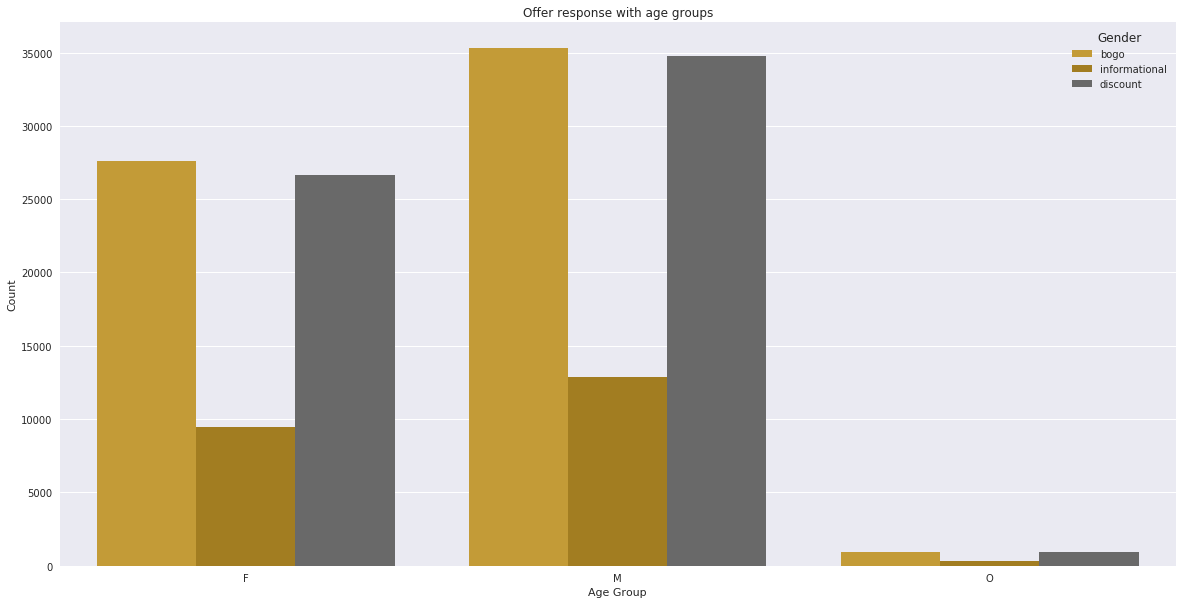

In [274]:

plt.figure(figsize=(20,10))
sns.countplot(x= "gender", hue= "offer_type", palette=['Goldenrod','DarkGoldenrod','DimGray'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

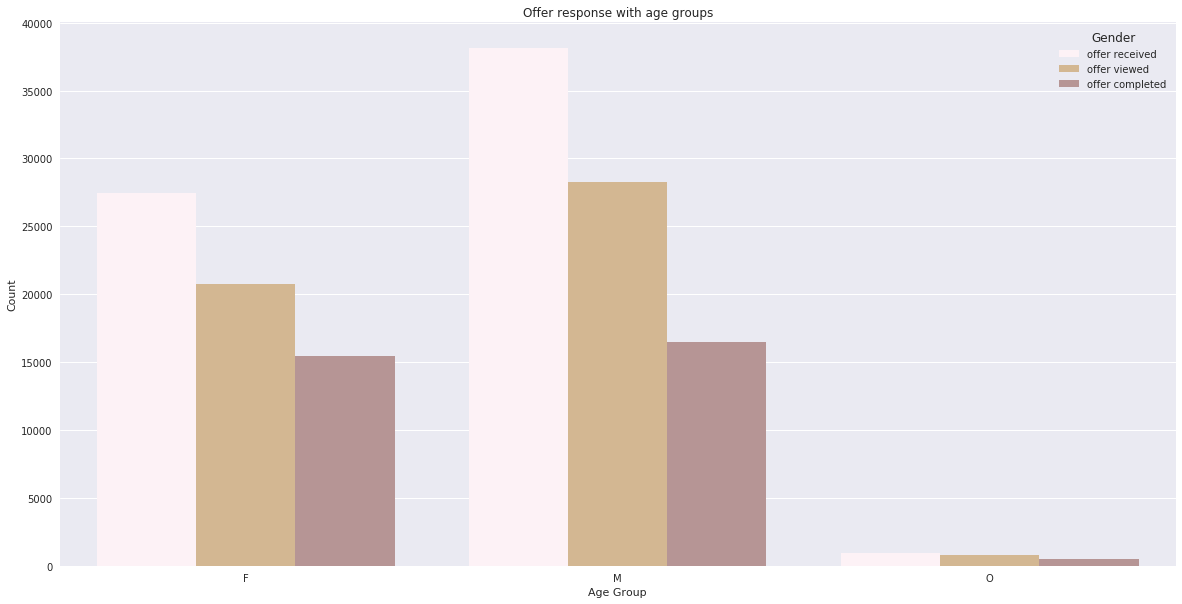

In [275]:

plt.figure(figsize=(20,10))
sns.countplot(x= "gender", hue= "event", palette=['LavenderBlush','BurlyWood','RosyBrown'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

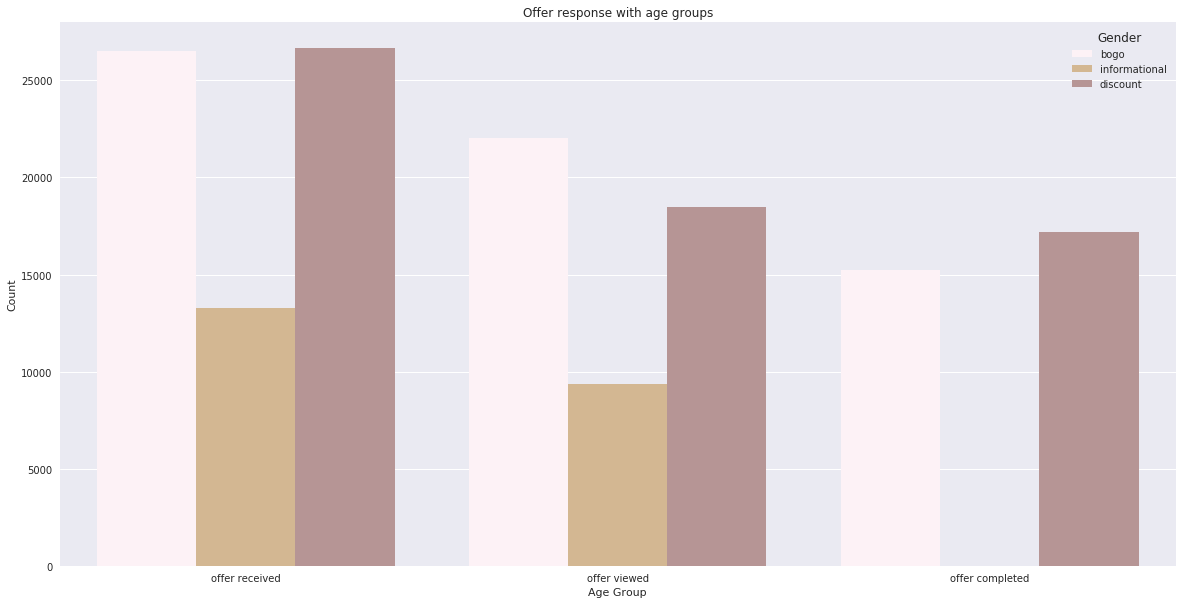

In [276]:

plt.figure(figsize=(20,10))
sns.countplot(x= "event", hue= "offer_type", palette=['LavenderBlush','BurlyWood','RosyBrown'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

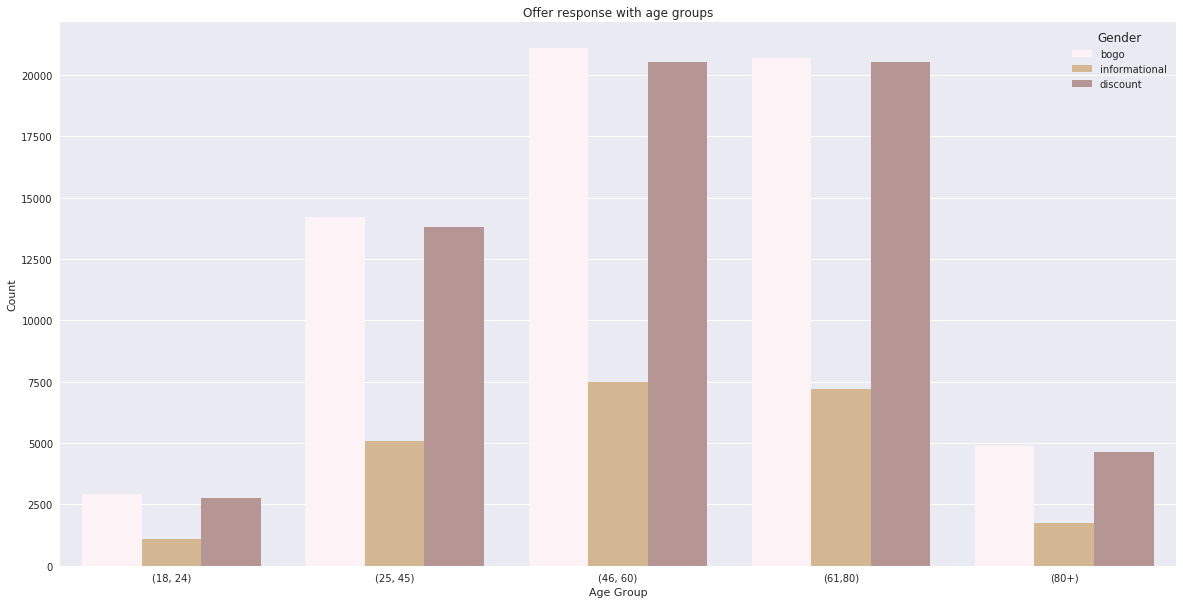

In [277]:

plt.figure(figsize=(20,10))
sns.countplot(x= "Age_Group", hue= "offer_type", palette=['LavenderBlush','BurlyWood','RosyBrown'], data=Starbucks_data)
sns.set(style="darkgrid")
plt.title('Offer response with age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

### Modelling

For this section I will try build a model that predicts customer response to an offer based on  offer type, age, gender, income.

To do it, I will need to
1. Encode the a. offer_type b.gender c. age_groups 
2. drop offer id offer_channels difficuty durations ,became_member_on
3. encode event 

In [278]:
#Check 
Starbucks_data.head()

,event,customer_id,time,offer_id,customer_spending,customer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_reward,became_member_on,gender,income,Age_Group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5,7,bogo,5,2017-05-09,F,100000.0,"(61,80)"
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5,5,bogo,5,2017-05-09,F,100000.0,"(61,80)"


In [279]:
# get dummy variables for offer types gender and age group and concat it
dummys =pd.get_dummies(Starbucks_data[['offer_type','gender','Age_Group']])
Starbucks_data = Starbucks_data.drop(['offer_type','gender','Age_Group','became_member_on'], 1)
Starbucks_data = Starbucks_data.join(dummys)

Note: add Programming notes

Event can be encoded to 
1. offer received ----> 1
2. offer viewed -----> 2
3. offer completed ------>3

In [280]:
# Map the offers
Starbucks_data['event'] = Starbucks_data['event'].map({"offer received":1,"offer viewed":2,"offer completed":3})

In [281]:
# Split the channels and drop it
Starbucks_data = Starbucks_data.drop('offer_channels', 1).join(Starbucks_data.offer_channels.str.join('|').str.get_dummies())

In [282]:
# Map offers to number
Starbucks_data['offer_id'] = Starbucks_data['offer_id'].map({'9b98b8c7a33c4b65b9aebfe6a799e6d9':'1','f19421c1d4aa40978ebb69ca19b0e20d':'2','ae264e3637204a6fb9bb56bc8210ddfd':'3','5a8bc65990b245e5a138643cd4eb9837':'4','2906b810c7d4411798c6938adc9daaa5':'5','fafdcd668e3743c1bb461111dcafc2a4':'6','4d5c57ea9a6940dd891ad53e9dbe8da0':'7','2298d6c36e964ae4a3e7e9706d1fb8c2':'8','3f207df678b143eea3cee63160fa8bed':'9','0b1e1539f2cc45b7b9fa7c272da2e1d7':'10'})

In [283]:
# Encode customer Id and drop it
customer_id = pd.factorize(Starbucks_data['customer_id'])
Starbucks_data = Starbucks_data.drop('customer_id',1)
customer_id1 = pd.Series(customer_id[0])
Starbucks_data['customer_ids'] = customer_id1

In [284]:
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['income', 'offer_difficulty', 'duration', 'offer_reward', 'time', 'customer_reward', 'customer_spending']
Starbucks_data[numerical] = scaler.fit_transform(Starbucks_data[numerical])
    

In [285]:
Starbucks_data.columns

Index(['event', 'time', 'offer_id', 'customer_spending', 'customer_reward',
       'offer_difficulty', 'duration', 'offer_reward', 'income',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'gender_F', 'gender_M', 'gender_O', 'Age_Group_(18, 24)',
       'Age_Group_(25, 45)', 'Age_Group_(46, 60)', 'Age_Group_(61,80)',
       'Age_Group_(80+)', 'email', 'mobile', 'social', 'web', 'customer_ids'],
      dtype='object')

I will test a couple of models to see which would have better accuracy starting with k neighbors

##### 2. Split the data into training and test set


In [286]:
# In this cell I will import needed sklearn functions for easier tracking
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, precision_score,fbeta_score,recall_score,accuracy_score,  f1_score,  make_scorer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier



In [287]:
data = Starbucks_data.drop('event',1)
labels = Starbucks_data['event']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 89283 rows
Testing set: 59522 rows


##### 3. Fit and test the model

###### 1. KNeighbors

In [289]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
Kneigh_y_pred = neigh.predict(X_test)
print(classification_report(y_test,Kneigh_y_pred))

             precision    recall  f1-score   support

          1       0.40      0.62      0.49     26652
          2       0.19      0.13      0.16     19931
          3       0.25      0.08      0.12     12939

avg / total       0.30      0.34      0.30     59522



###### 2. DecisionTree

In [290]:
trees =   DecisionTreeClassifier(random_state = 10)
trees.fit(X_train, y_train)
trees_y_pred = trees.predict(X_test)
print(classification_report(y_test, trees_y_pred ))

             precision    recall  f1-score   support

          1       0.84      0.84      0.84     26652
          2       0.79      0.79      0.79     19931
          3       1.00      1.00      1.00     12939

avg / total       0.86      0.86      0.86     59522



##### 3. Random Forests

In [291]:
Forest =  RandomForestClassifier( random_state=10)
Forest.fit(X_train, y_train)
Forest_y_pred = Forest.predict(X_test)
print(classification_report(y_test, Forest_y_pred ))

             precision    recall  f1-score   support

          1       0.71      0.79      0.75     26652
          2       0.67      0.57      0.62     19931
          3       1.00      1.00      1.00     12939

avg / total       0.76      0.76      0.76     59522

